In [1]:
import random

random.seed(42)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os

from PIL import Image
import imagesize

from sklearn.preprocessing import LabelEncoder

In [2]:
bloodcells = os.listdir("bloodcells_dataset")

print(bloodcells)

bloodcells.remove('.DS_Store')
bloodcells.remove('All_Images')

['basophil', 'neutrophil', '.DS_Store', 'ig', 'monocyte', 'All_Images', 'eosinophil', 'erythroblast', 'lymphocyte', 'platelet']


In [3]:
images = os.listdir('bloodcells_dataset/' + bloodcells[0])
df = pd.DataFrame(data = {'images': images, 'type': bloodcells[0], 'height': np.nan, 'width': np.nan})

for i in range(1, len(bloodcells)):

    images = os.listdir('bloodcells_dataset/' + bloodcells[i]) # jpg string paths
    
    images_df = pd.DataFrame(data = {'images': images, 'type': bloodcells[i], 'height': np.nan, 'width': np.nan})
    
    df = pd.concat([df, images_df])

le = LabelEncoder()

df['width'] = df['images'].apply(lambda x: imagesize.get('bloodcells_dataset/All_Images/' + x)[0])
df['height'] = df['images'].apply(lambda x: imagesize.get('bloodcells_dataset/All_Images/' + x)[1])
df['type'] = le.fit_transform(df['type'])
df.index = range(len(df.index))
df = df[df["images"].str.contains("copy") == False]

df

,images,type,height,width
0,BA_689200.jpg,0,363,360
1,BA_883452.jpg,0,363,360
2,BA_382161.jpg,0,369,366
3,BA_175579.jpg,0,363,360
4,BA_775722.jpg,0,363,360
...,...,...,...,...
20204,PLATELET_495918.jpg,7,363,360
20205,PLATELET_897238.jpg,7,363,360
20206,PLATELET_750430.jpg,7,363,360
20207,PLATELET_810431.jpg,7,363,360


In [4]:
df[['height', 'width']].value_counts().reset_index(name = 'count')

,height,width,count
0,363,360,16639
1,369,366,250
2,360,360,198
3,361,360,2
4,360,359,1
5,360,361,1
6,360,362,1


In [5]:
category_counts = df[['type']].value_counts().reset_index(name = 'count')

total_num_images = category_counts['count'].sum()

category_counts

,type,count
0,6,3329
1,1,3117
2,3,2895
3,7,2348
4,2,1551
5,5,1420
6,0,1218
7,4,1214


In [6]:
# Weighted Sampling

# high representation - types 1, 3, 6, 7 (sample 1500)
# low representation - types 0, 2, 4, 5 (sample 1000)

df_weighted_sampling_train = df[df['type'] == 6].sample(1500)

for i in range(1, len(category_counts)):

    type = category_counts['type'][i]

    if category_counts['count'][i] >= 2000:
        add_samples = df[df['type'] == type].sample(1500)
    else: 
        add_samples = df[df['type'] == type].sample(1000)

    df_weighted_sampling_train = pd.concat([df_weighted_sampling_train, add_samples])

df_weighted_sampling_test = df[~df['images'].isin(df_weighted_sampling_train['images'])]

df_weighted_sampling_train["type"].value_counts().reset_index(name = "count")

#weighted_sampling_train = np.array(
    #[np.array(Image.open('bloodcells_dataset/All_Images/' + image).resize((300, 300))) for image in df_weighted_sampling_train['images']]
#)

#weighted_sampling_test = np.array(
    #[np.array(Image.open('bloodcells_dataset/All_Images/' + image).resize((300, 300))) for image in df_weighted_sampling_test['images']]
#)

,type,count
0,6,1500
1,1,1500
2,3,1500
3,7,1500
4,2,1000
5,5,1000
6,0,1000
7,4,1000


In [7]:
# Proportional Sampling

num_samples = int(0.8 * total_num_images)

category_counts['prop'] = category_counts['count'] / total_num_images
category_counts['prop_samples'] = category_counts['prop'] * num_samples
category_counts['prop_samples'] = category_counts['prop_samples'].astype('int32')

df_prop_sampling_train = df[df['type'] == 6].sample(2663)

for i in range(1, len(category_counts)):

    type = category_counts['type'][i]

    samples = category_counts['prop_samples'][i]

    add_samples = df[df['type'] == type].sample(samples)

    df_prop_sampling_train = pd.concat([df_prop_sampling_train, add_samples])

df_prop_sampling_test = df[~df['images'].isin(df_prop_sampling_train['images'])]

# weighted_prop_train = np.array(
#     [np.array(Image.open('bloodcells_dataset/All_Images/' + image).resize((300, 300))) for image in df_prop_sampling_train['images']]
# )

# weighted_prop_test = np.array(
#     [np.array(Image.open('bloodcells_dataset/All_Images/' + image).resize((300, 300))) for image in df_prop_sampling_test['images']]
# )

## Visuals of the Sampled Data

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


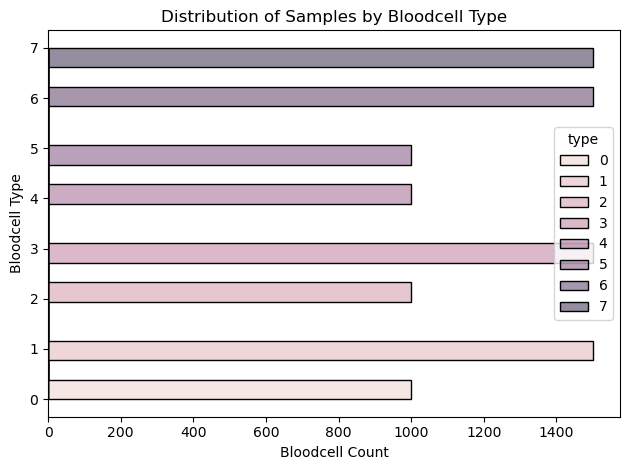

In [12]:
#create visuals for weighted vs downsampled training data to show the difference in proportionality compared to the original dataset

fig = sns.histplot(y = df_weighted_sampling_train["type"], hue = df_weighted_sampling_train["type"])
plt.xlabel("Bloodcell Count")
plt.ylabel("Bloodcell Type")
plt.title("Distribution of Samples by Bloodcell Type")
plt.tight_layout()
plt.show()


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


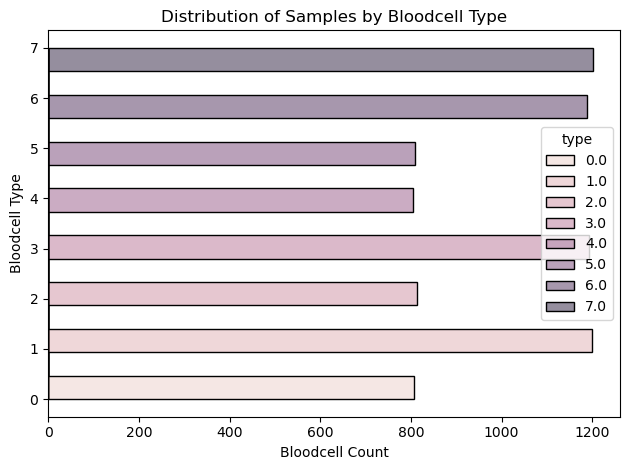

In [11]:
#proportional visual

fig = sns.histplot(y = df_prop_sampling_train["type"], hue = df_weighted_sampling_train["type"])
plt.xlabel("Bloodcell Count")
plt.ylabel("Bloodcell Type")
plt.title("Distribution of Samples by Bloodcell Type")
plt.tight_layout()
plt.show()


In [10]:
# Opening an image
# test_img = Image.open('bloodcells_dataset/All_Images/' + df['images'][14000])

# Resize
# test_img.resize((320, 320))

# Crop
# test_img.crop((20, 20, 340, 340))